In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import trimesh
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

References: Keras Tutorial Version, https://keras.io/examples/vision/pointnet/

In [4]:
prj_path = Path().absolute().parent
data_path = prj_path.parent / "data" / "modelnet" / "ModelNet10"

In [5]:
mesh = trimesh.load( str(data_path / "chair/train/chair_0001.off") )
mesh.show()

ValueError: string is not a file: C:\Users\simon\Desktop\Codes\data\modelnet\ModelNet10\chair\train\chair_0001.off

## Concepts that should know

### Point Cloud

(2048, 3)


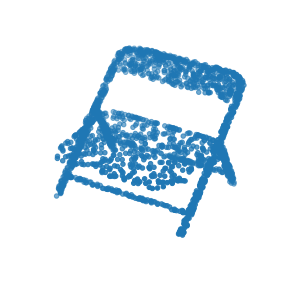

In [4]:
N = 2048
points = mesh.sample(N)
print(points.shape)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [5]:
# normalisation
points_mean = np.mean(points, axis=0)
points_sub = points - points_mean[np.newaxis, :]
dist = np.max(np.sqrt(np.sum(points_sub**2, axis=1)), 0)
points_normed = points_sub / dist

### Affine transformation

[Affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) is a geometric transformation that preserves lines and parallelism (but not necessarily distances and angles).

#### 2D:

General form:

$$\begin{bmatrix} x^{'} \\ y^{'} \end{bmatrix} = 
\begin{bmatrix} \theta_{11} & \theta_{12} \\ \theta_{21} & \theta_{22} \end{bmatrix}\begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} \theta_{13} \\ \theta_{23} \end{bmatrix}$$

Homogeneous Form:

$$\begin{bmatrix} x^{'} \\ y^{'} \\ 1 \end{bmatrix} = \begin{bmatrix} \theta_{11} & \theta_{12} & \theta_{13} \\ \theta_{21} & \theta_{22} & \theta_{23} \\ 0 & 0 & 1\end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$

#### 3D:

General form:

$$
\begin{bmatrix}x^{'} \\ y^{'} \\ z^{'}\end{bmatrix} = \begin{bmatrix}
\theta_{11} & \theta_{12} & \theta_{13} \\
\theta_{21} & \theta_{22} & \theta_{23} \\
\theta_{31} & \theta_{32} & \theta_{33}
\end{bmatrix}
\begin{bmatrix}x \\ y \\ z \end{bmatrix} 
+ \begin{bmatrix} \theta_{14} \\ \theta_{24}\\ \theta_{34} \end{bmatrix}
$$

Homogeneous Form:

$$
\begin{bmatrix}x^{'} \\ y^{'} \\ z^{'} \\ 1 \end{bmatrix} = \begin{bmatrix}
\theta_{11} & \theta_{12} & \theta_{13} & \theta_{14} \\
\theta_{21} & \theta_{22} & \theta_{23} & \theta_{24} \\
\theta_{31} & \theta_{32} & \theta_{33} & \theta_{34} \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}x \\ y \\ z \\ 1\end{bmatrix}$$

Ref: 
* [Geometric Transformation with numpy](https://stackabuse.com/affine-image-transformations-in-python-with-numpy-pillow-and-opencv/)
* [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025)



In [6]:
def draw_points(points, points2=None, axisoff=True):
    size = 5
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    if points2 is not None:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=size)
        ax.scatter(points2[:, 0], points2[:, 1], points2[:, 2], c="r", s=size, alpha=0.3)
    else:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=size)
    if axisoff:
        ax.set_axis_off()
    else:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
    plt.show()

$$\text{identity} = \begin{bmatrix} 
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}$$

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


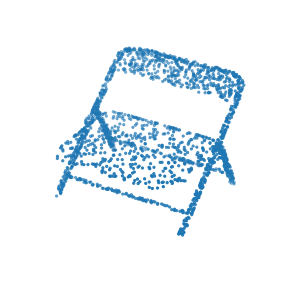

In [7]:
ps = np.concatenate((points_normed, np.ones((N,1))), axis=1)
# Identity
trans_matrix = np.eye(4)

trans_iden = ps @ trans_matrix.T  # Transpose is for the batch multiplication
print(trans_matrix)

draw_points(trans_iden)

$$\text{scaling} = \begin{bmatrix} 
c_x & 0 & 0 & 0\\
0 & c_y & 0 & 0\\
0 & 0 & c_z & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$$

[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 1.]]


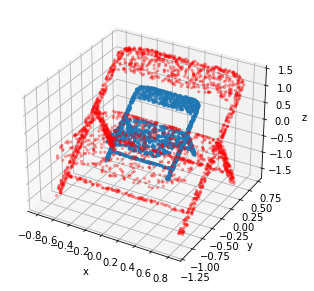

In [8]:
# Scaling
c_x = 2
c_y = 2
c_z = 2
trans_matrix = np.eye(4)
trans_matrix[0, 0] *= c_x
trans_matrix[1, 1] *= c_y
trans_matrix[2, 2] *= c_z

trans_scale = ps @ trans_matrix.T
print(trans_matrix)

draw_points(trans_iden, trans_scale, False)

$$\begin{aligned} 
\text{rotation x} &= 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & \cos\theta & \sin\theta & 0 \\
0 & -\sin\theta & \cos\theta & 0 \\
0 & 0 & 0 & 1
\end{bmatrix} \\
\text{rotation y} &= 
\begin{bmatrix}
\cos\theta & 0 & -\sin\theta & 0 \\
0 & 1 & 0 & 0 \\
\sin\theta & 0 & \cos\theta & 0 \\
0 & 0 & 0 & 1
\end{bmatrix} \\
\text{rotation z} &= 
\begin{bmatrix}
\cos\theta & -\sin\theta & 0 & 0 \\
\sin\theta & \cos\theta & 0 & 0\\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{aligned}$$

[[ 1.          0.          0.          0.        ]
 [ 0.          0.70710678  0.70710678  0.        ]
 [ 0.         -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]]


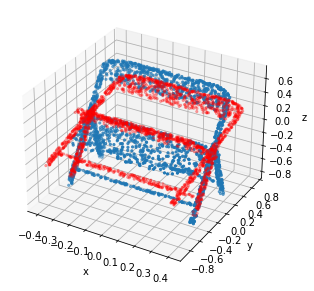

In [9]:
# Rotation X
r = 45*np.pi / 180
cos = np.cos(r)
sin = np.sin(r)
trans_matrix = np.array([
    [    1,    0,    0,    0],
    [    0,  cos,  sin,    0],
    [    0, -sin,  cos,    0],
    [    0,    0,    0,    1]
])

trans_rotate = ps @ trans_matrix.T
print(trans_matrix)

draw_points(trans_iden, trans_rotate, False)

[[ 0.70710678  0.         -0.70710678  0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]]


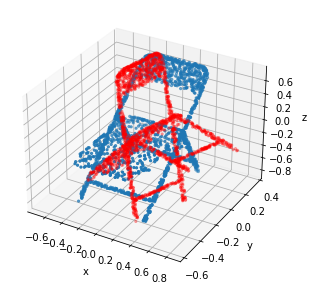

In [10]:
# Rotation Y
trans_matrix = np.array([
    [  cos,    0, -sin,    0],
    [    0,    1,    0,    0],
    [  sin,    0,  cos,    0],
    [    0,    0,    0,    1]
])

trans_rotate = ps @ trans_matrix.T
print(trans_matrix)

draw_points(trans_iden, trans_rotate, False)

[[ 0.70710678 -0.70710678  0.          0.        ]
 [ 0.70710678  0.70710678  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


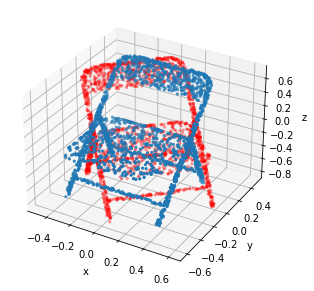

In [11]:
# Rotation Z
trans_matrix = np.array([
    [  cos, -sin,    0,    0],
    [  sin,  cos,    0,    0],
    [    0,    0,    1,    0],
    [    0,    0,    0,    1]
])

trans_rotate = ps @ trans_matrix.T
print(trans_matrix)

draw_points(trans_iden, trans_rotate, False)

$$\text{translation} = \begin{bmatrix} 
1 & 0 & 0 & t_x \\
0 & 1 & 0 & t_y \\
0 & 0 & 1 & t_z \\
0 & 0 & 0 & 1
\end{bmatrix}$$

[[1.  0.  0.  1.5]
 [0.  1.  0.  1.5]
 [0.  0.  1.  1.5]
 [0.  0.  0.  1. ]]


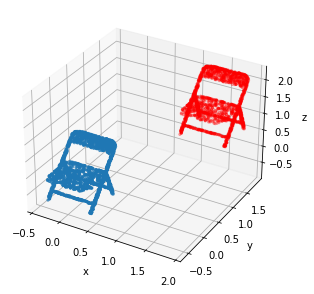

In [12]:
# Translation
t_x = +1.5
t_y = +1.5
t_z = +1.5
trans_matrix = np.eye(4)
trans_matrix[0, 3] += t_x
trans_matrix[1, 3] += t_y
trans_matrix[2, 3] += t_y

trans_trans = ps @ trans_matrix.T
print(trans_matrix)

draw_points(trans_iden, trans_trans, False)

$$\text{shear x} = \begin{bmatrix} 
1 & \cot\theta & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}$$

[[1. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


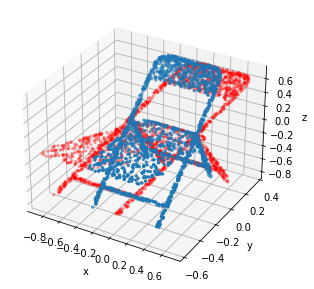

In [13]:
s_h = cos / sin
trans_matrix = np.eye(4)
trans_matrix[0, 1] += s_h

trans_hs = ps @ trans_matrix.T
print(trans_matrix)

draw_points(trans_iden, trans_hs, False)

$$\text{shear y } = \begin{bmatrix} 
1 & 0 & 0 & 0 \\
\cot \theta & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}$$

[[1. 0. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


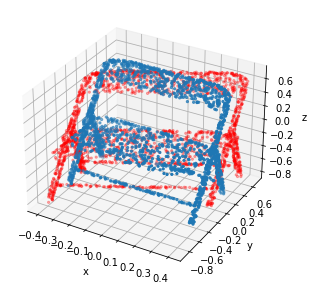

In [14]:
# Vertical Shear
s_v = cos / sin
trans_matrix = np.eye(4)
trans_matrix[1, 0] += s_v

trans_vs = ps @ trans_matrix.T
print(trans_matrix)

draw_points(trans_iden, trans_vs, False)

## Create Dataset

In [15]:
# TBD

## Model

<img src="https://drive.google.com/uc?id=1ZZbw0itgC1p1wMHW-ZLEYM03PP9wz-pU" alt="pointnet-model" width="720" height="360">


### Transform Network(T-Net)

for a given input point cloud, apply an appropriate rigid or affine transformation to achieve pose normalization. Because each of the $N$ input points are represented as a vector and are mapped to the embedding spaces independently, applying a geometric transformation simply amounts to matrix multiplying each point with a transformation matrix. 

For example, Input Transformation Parameter $A_\theta$:

In General Form:

$$\begin{aligned}
\begin{bmatrix}x_i^s \\ y_i^s \\ z_i^s\end{bmatrix} = \begin{bmatrix}
\theta_{11} & \theta_{12} & \theta_{13} \\
\theta_{21} & \theta_{22} & \theta_{23} \\
\theta_{31} & \theta_{32} & \theta_{33}
\end{bmatrix}
\begin{bmatrix}x_i^t \\ y_i^t \\ z_i^t \end{bmatrix} 
+ \begin{bmatrix} \theta_{14} \\ \theta_{24}\\ \theta_{34} \end{bmatrix}
\end{aligned} \quad \text{ for } i \text{ in } (1, \cdots, N)$$

In Homogenious Form:

$$\begin{aligned}
\begin{bmatrix}x_i^s \\ y_i^s \\ z_i^s \\ 1 \end{bmatrix} &= A_\theta \begin{bmatrix}x_i^t \\ y_i^t \\ z_i^t \\ 1 \end{bmatrix} \\
&= \begin{bmatrix}
\theta_{11} & \theta_{12} & \theta_{13} & \theta_{14} \\
\theta_{21} & \theta_{22} & \theta_{23} & \theta_{24}\\
\theta_{31} & \theta_{32} & \theta_{33} & \theta_{34} \\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}x_i^t \\ y_i^t \\ z_i^t \\ 1 \end{bmatrix}
\end{aligned} \quad \text{ for } i \text{ in } (1, \cdots, N)$$

So the output of mini-pointnet is the parameters of transform matrix

An orthogonal transformation will not lose information in the input, thus is desired.
https://en.wikipedia.org/wiki/Orthogonal_transformation

In [4]:
class TNetConvModule(nn.Module):
    """Transform Network Convolution Module"""
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.bn = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        return torch.relu(self.bn(self.conv(x)))
    
    
class TNetFcModule(nn.Module):
    """Transform Network Fully Connected Module"""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        
    def forward(self, x):
        return torch.relu(self.bn(self.linear(x)))
    
class TransformNet(nn.Module):
    """Mini PointNet: T-Net"""
    def __init__(self, k):
        r"""
        Args:
            - k: transformation size
        """
        super().__init__()
        self.k = k 
        self.conv1 = TNetConvModule(self.k, 64, 1)
        self.conv2 = TNetConvModule(64, 128, 1)
        self.conv3 = TNetConvModule(128, 1024, 1)
        self.fc1 = TNetFcModule(1024, 512)
        self.fc2 = TNetFcModule(512, 256)
        # geometric transformation parameters (K, K) shape
        # the structure is related to Spatial Transformer Network
        # https://arxiv.org/abs/1506.02025
        self.geotrans = nn.Linear(256, self.k*self.k) 
        
        nn.init.zeros_(self.geotrans.weight.data)
        nn.init.zeros_(self.geotrans.bias.data)
        
    def forward(self, x):
        r"""
        B: Batch size
        C: Input Channel size
        N: Number of points
        -------------------------
        Inputs:
            - x: point cloud (B, C, N)
        """
        B = x.size(0)
        x = self.conv1(x)  # (B, C, N) --> (B, 64, N)  
        x = self.conv2(x)  # (B, 64, N) --> (B, 128, N)
        x = self.conv3(x)  # (B, 128, N) --> (B, 1024, N)
        x = torch.max(x, 2, keepdim=True)[0].squeeze(-1)  # (B, 1024, N) --> (B, 1024)  
        print(x.size())
        x = self.fc1(x)  # (B, 1024) --> (B, 512)
        x = self.fc2(x)  # (B, 512) --> (B, 256)
        x = self.geotrans(x)  # (B, 256) --> (B, K*K)
        
        iden = torch.eye(self.k).flatten().repeat(B, 1).to(x.device)
        x += iden
        return x.view(-1, self.k, self.k)

### Feature Network

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self, global_feat=True, feature_transform=False):
        super().__init__()
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        self.input_trans = TransformNet(3)
        self.conv1 = TNetConvModule(3, 64, 1)
        self.conv2 = TNetConvModule(64, 64, 1)
        if self.feature_transform:
            self.feature_trans = TransformNet(64)
        self.conv3 = TNetConvModule(64, 64, 1)
        self.conv4 = TNetConvModule(64, 128, 1)
        self.conv5 = TNetConvModule(128, 1024, 1)
        
    def forward(self, x):
        r"""
        Input:
            - x: Point Cloud (B, C, N)
        """
        N = x.size(2)  # size of points
        trans_i = self.input_trans(x)  # (B, 3, 3)
        x = x.transpose(1, 2).bmm(trans_i).transpose(1, 2)  # (B, N, 3) * (B, 3, 3) = (B, N, 3) --> (B, 3, N)
        x = self.conv1(x)  # (B, 3, N) --> (B, 64, N)
        x = self.conv2(x)  # (B, 64, N) --> (B, 64, N)
        if self.feature_transform:
            trans_f = self.feature_trans(x)  # (B, 64, 64)
            x = x.transpose(1, 2).bmm(trans_f).transpose(1, 2)  # (B, N, 64) * (B, 64, 64) = (B, N, 64) --> (B, 64, N)
        else:
            trans_f = None
        
        seg_f = x if not self.global_feat else None
        x = self.conv3(x)  # (B, 64, N) --> (B, 64, N)
        x = self.conv4(x)  # (B, 64, N) --> (B, 128, N)
        x = self.conv5(x)  # (B, 128, N) --> (B, 1024, N)
        x = torch.max(x, 2, keepdim=True)[0]  # (B, 1024, N) --> (B, 1024, 1)
        
        if self.global_feat:
            return x.squeeze(-1), trans_i, trans_f
        else:
            x = torch.cat([seq_f, x.repeat(1, 1, N)], axis=1)  # (B, 64+1024, N)
            return x, trans_i, trans_f

### Classifier

In [ ]:
class PointNetCls(nn.Module):
    def __init__(self, output_size, feature_transform=False, dropout_rate=0.3):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.feature_transform = feature_transform
        self.feature_extractor = FeatureExtractor(global_feat=True, feature_transform)
        self.fc1 = TNetFcModule(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(256, output_size)
        
    def forward(self, x):
        x, trans_i, trans_f = self.feature_extractor(x)  # (B, C, N) --> (B, 1024), (B, 3, 3), (B, 64, 64)
        x = self.fc1(x)  # (B, 1024) --> (B, 512)
        x = torch.relu(self.bn2(self.dropout(self.fc2(x))))  # (B, 512) --> (B, 256)
        x = self.fc3(x)    # (B, 356) --> (B, O)
        
        return x, trans_i, trans_f
    
        
class PointNetSeg(nn.Module):
    def __init__(self, output_size, feature_transform=False):
        self.output_size = output_size
        self.feature_transform = feature_transform
        self.feature_extractor = FeatureExtractor(global_feat=True, feature_transform)
        self.conv1 = TNetConvModule(1088, 512, 1)
        self.conv2 = TNetConvModule(512, 256, 1)
        self.conv3 = TNetConvModule(256, 128, 1)
        self.conv4 = nn.Conv1d(128, output_size, 1)
                
    def forward(self, x):
        x, trans_i, trans_f = self.feature_extractor(x)  # (B, C, N) --> (B, N, 1088), (B, 3, 3), (B, 64, 64)
        x = self.conv1(x)  # (B, 1088, N) --> (B, 512, N)
        x = self.conv2(x)  # (B, 512, N) --> (B, 256, N)
        x = self.conv3(x)  # (B, 256, N) --> (B, 128, N)
        x = self.conv4(x)  # (B, 128, N) --> (B, O, N)
        return x, trans_i, trans_f
    
        

In [ ]:
class PointNet(pl.LightningModule):
    def __init__(self, model_type, output_size, feature_transform):
        super().__init__()
        if model_type == "cls":
            self.net = PointNetCls(output_size, feature_transform)
        else:
            self.net = PointNetSeg(output_size, feature_transform)
            
        